## Script para plotagem dos dados gravimétricos terrestres referentes a Bacia de Barreirinhas (dados adquiridos por Nelson Delimar - Nielsen)

In [1]:
# importando as bibliotecas necessarias para o uso do script:
# import necessary library:
import numpy as np
import pylab as py
from numpy.linalg import inv, solve
import matplotlib.pyplot as plt
import pandas as pd
#from mpl_toolkits.basemap import Basemap
from matplotlib.patches import Polygon
from scipy.interpolate import Rbf, griddata # radial basis functions technique
import utm
# to plot figures in cells:
%matplotlib inline

In [2]:
# importacao das funções externas ao anaconda:
from modules.auxiliars import inv_power_dist

In [3]:
# Diretorios das maquinas do Rod e do Mat:

caminhomat= '../dados_reais/'
caminhorod= '../dados_reais/Barreirinhas/'


In [4]:
# leitura dos dados via pandas e via numpy:

# 1) dados do nielsen:
#data = pd.read_table (caminhomat + 'data_barreirinhas.txt')
data = pd.read_table (caminhorod + 'data_barreirinhas.txt')

# 2) dados de satelite (potzdam): 
#lon_sat, lat_sat, gz_sat = np.loadtxt( caminhomat + 'barreirinhas_satelite.gdf', skiprows=35, 
#                                      usecols=(0,1,3), unpack=True)

lon_sat, lat_sat, gz_sat = np.loadtxt( caminhorod + 'barreirinhas_satelite.gdf', skiprows=35, 
                                      usecols=(0,1,3), unpack=True) 


# variaveis para usar a funcao plota mapa:
lon_sat = lon_sat -360.0  # correcao de quadrante 

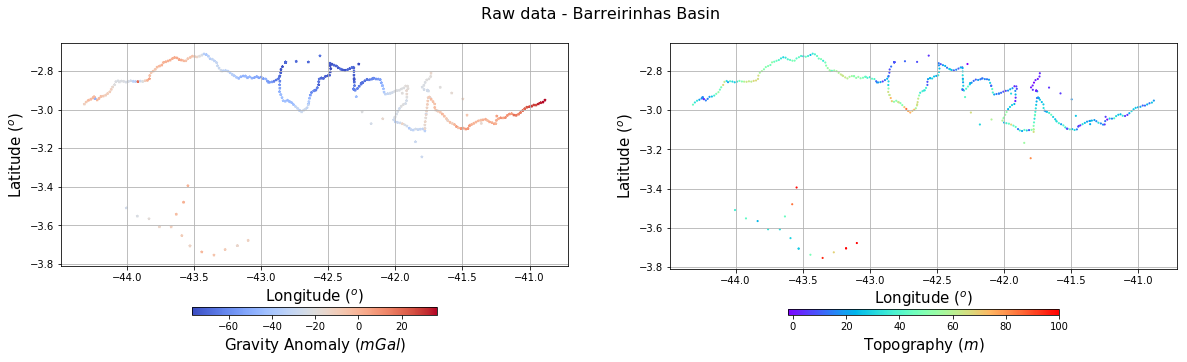

In [5]:
# leitura dos dados via pandas:
# ------------ plot the flight lines to check for the interpolation:--------#
# ------------ set figure size: ------------------------------------------#
plt.close('all')
fig = plt.figure(figsize=(20,5), facecolor='w' )

plt.subplot(1,2,1)
fig.suptitle('Raw data - Barreirinhas Basin', fontsize=16)
plt.xlabel('Longitude ($^o$)', fontsize = 15)
plt.ylabel('Latitude ($^o$)', fontsize = 15)
p1 = plt.scatter(data['Longitude'], data['Latitude'], s=5.0, c=data['BG (mGal)'], marker='*', cmap=plt.cm.coolwarm)
cbar = plt.colorbar(p1, aspect=30, fraction = 0.03, orientation="horizontal")
cbar.set_label('Gravity Anomaly $ (mGal) $',fontsize=15, rotation = 0)
plt.grid()
###########################################################################################################################

plt.subplot(1,2,2)
plt.xlabel('Longitude ($^o$)', fontsize = 15)
plt.ylabel('Latitude ($^o$)', fontsize = 15)

p2  = plt.scatter(data['Longitude'], data['Latitude'], s=5.0, c=data['H (m)'], marker='.', cmap=plt.cm.rainbow)
cbar= plt.colorbar(p2, aspect=50, fraction = 0.02, orientation="horizontal")
cbar.set_label('Topography $ (m) $',fontsize=15, rotation = 0)
plt.grid()
plt.show()

##  <center> Remocao de outliers dos dados: <center> 

In [6]:
# Etapa 01: seleção do range indesejavel:
df = data.loc[ (data['Longitude'] < -43.0) & (data['Latitude'] < -3.2 ) ]

In [7]:
df

,Station,Longitude,Latitude,X (m),Y (m),H (m),G (mGal),FA (mGal),BG (mGal),N (m)
0,2665,-43.530317,-3.706367,663217.0,9590194.0,27.78,978034.790,-10.064,-13.172,-22.22
1,NF1,-43.442562,-3.737688,672959.0,9586714.0,47.53,978043.191,4.070,-1.250,-21.98
2,NF2,-43.351662,-3.753989,683053.0,9584893.0,94.67,978029.392,4.630,-5.970,-21.75
3,NF3,-43.268513,-3.725343,692296.0,9588043.0,68.85,978031.336,-1.060,-8.770,-21.55
4,NF4,-43.177110,-3.705030,702455.0,9590269.0,99.64,978021.899,-0.760,-11.910,-21.42
5,NF5,-43.177119,-3.705039,711380.0,9593245.0,99.68,978019.125,-3.520,-14.680,-21.42
6,NF6,-43.096836,-3.677951,720392.0,9591545.0,100.01,978021.650,-0.580,-11.780,-21.31
7,NF7,-43.590917,-3.652969,656495.0,9596109.0,29.62,978037.536,-6.130,-9.450,-22.37
8,NF8,-43.670248,-3.608194,647690.0,9601073.0,32.45,978035.078,-7.200,-10.840,-22.62
9,NF9,-43.757858,-3.607803,637958.0,9601130.0,34.07,978031.208,-10.570,-14.390,-23.00


In [8]:
# remover as linhas armazenadas no array indices:
df = data.drop(df.index.values)

In [9]:
# por em ordem em função da longitude(coluna 2)
ds = df.sort_values(by=['Longitude'], ascending=True)

In [10]:
# remove valores repetidos em diferentes linhas (Mathews descobriu como fazer remoçoes de duplicatas via pandas!:
ds.drop_duplicates( ['Longitude','Latitude'], keep='first', inplace=True )

In [11]:
ds

,Station,Longitude,Latitude,X (m),Y (m),H (m),G (mGal),FA (mGal),BG (mGal),N (m)
70,M101,-44.317164,-2.971774,575882.0,9671503.0,44.81,978025.251,-6.650,-11.660,-24.68
71,M102,-44.303052,-2.960658,577451.0,9672731.0,33.63,978031.413,-3.830,-7.600,-24.62
72,M103,-44.286965,-2.951932,579240.0,9673694.0,34.89,978036.963,2.190,-1.720,-24.56
73,M104,-44.269638,-2.946724,581166.0,9674268.0,20.75,978039.201,0.110,-2.210,-24.51
74,M105,-44.253402,-2.940351,582971.0,9674972.0,18.49,978040.470,0.740,-1.330,-24.46
69,BASE1,-44.245227,-2.935012,583880.0,9675561.0,16.60,978040.360,0.097,-1.761,-24.43
75,M106,-44.237163,-2.943438,584775.0,9674629.0,3.08,978039.644,-4.870,-5.210,-24.41
76,M107,-44.221693,-2.950419,586494.0,9673856.0,15.14,978041.222,0.360,-1.330,-24.36
77,M108,-44.207788,-2.942243,588040.0,9674759.0,15.00,978041.093,0.270,-1.410,-24.30
78,M109,-44.194085,-2.932009,589564.0,9675889.0,20.06,978036.681,-2.490,-4.730,-24.24


In [12]:
# salvando arquivo para georeferenciamento:
ds.to_csv(caminhomat + 'caminhamento.csv', sep = ' ', encoding='utf-8')

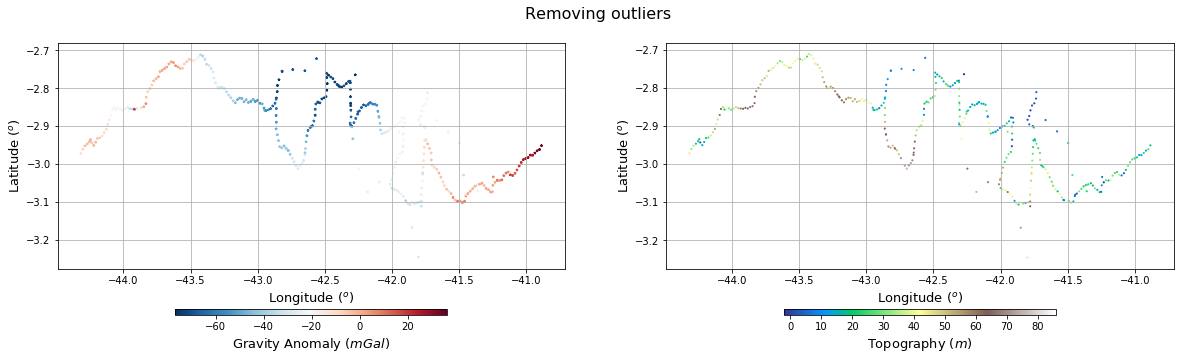

In [13]:
# ------------ set figure size: ------------------------------------------#
plt.close('all')
fig = plt.figure(figsize=(20,5), facecolor='w')
plt.subplot(1,2,1)

fig.suptitle('Removing outliers', fontsize=16)
plt.xlabel('Longitude ($^o$)', fontsize = 13)
plt.ylabel('Latitude ($^o$)', fontsize = 13)
p1 = plt.scatter(np.array(ds['Longitude']), np.array(ds['Latitude']), s=5.0, c=np.array(ds['BG (mGal)']), marker='*', cmap='RdBu_r')
cbar = plt.colorbar(p1, aspect=50, fraction = 0.02, orientation="horizontal")
cbar.set_label('Gravity Anomaly $ (mGal) $',fontsize=13, rotation = 0)
plt.grid()
###########################################################################################################################

plt.subplot(1,2,2)
plt.xlabel('Longitude ($^o$)', fontsize = 13)
plt.ylabel('Latitude ($^o$)', fontsize = 13)

p2  = plt.scatter(np.array(ds['Longitude']), np.array(ds['Latitude']), s=5.0, c=np.array(ds['H (m)']), marker='.', cmap='terrain')
cbar= plt.colorbar(p2, aspect=50, fraction = 0.02, orientation="horizontal")
cbar.set_label('Topography $ (m) $',fontsize=13, rotation = 0)
plt.grid()
plt.show()

## processameintu: Definicao dos novos ranges dos dados:

In [14]:

# Etapa 01: seleção do range indesejavel:
ds2 = ds.loc[ (ds['Longitude'] < -41.5) & (ds['Longitude'] > -44.0 ) ]

In [15]:
ds2

,Station,Longitude,Latitude,X (m),Y (m),H (m),G (mGal),FA (mGal),BG (mGal),N (m)
92,M123,-43.989176,-2.854281,612346.0,9684464.0,35.38,978013.926,-19.810,-23.770,-23.63
93,M124,-43.971398,-2.850680,614323.0,9684860.0,47.83,978010.074,-19.780,-25.140,-23.59
94,M125,-43.952980,-2.853699,616370.0,9684524.0,51.37,978001.866,-26.930,-32.680,-23.52
95,M126,-43.936180,-2.854481,618237.0,9684436.0,59.75,977998.826,-27.390,-34.080,-23.47
96,M127,-43.918157,-2.855169,620240.0,9684358.0,64.21,978052.233,27.390,20.200,-23.40
97,M128,-43.900481,-2.852823,622205.0,9684616.0,62.70,978004.469,-20.820,-27.840,-23.34
98,M129,-43.882685,-2.854410,624183.0,9684438.0,61.34,978012.129,-13.600,-20.460,-23.28
99,M130,-43.865288,-2.850549,626118.0,9684863.0,66.94,978020.842,-3.120,-10.610,-23.22
100,M131,-43.847726,-2.848493,628070.0,9685089.0,66.63,978031.618,7.580,0.120,-23.17
101,M132,-43.832924,-2.840501,629716.0,9685971.0,65.37,978036.903,12.550,5.230,-23.13


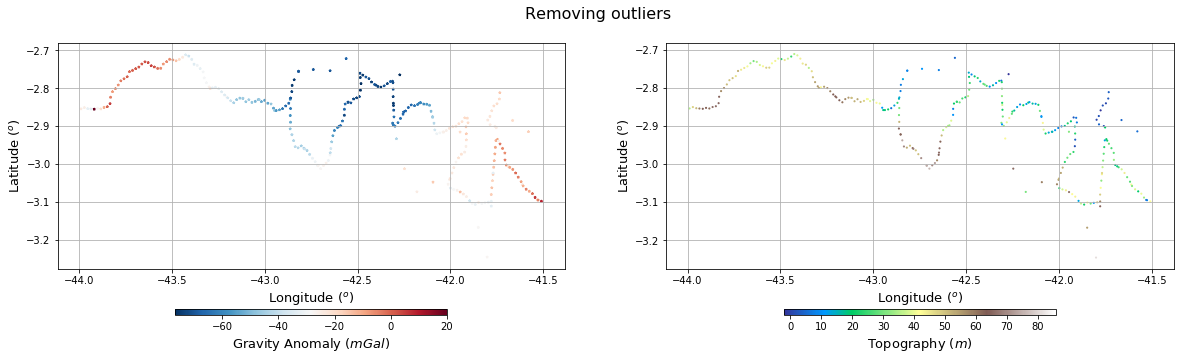

In [16]:
# ------------ set figure size: ------------------------------------------#
plt.close('all')
fig = plt.figure(figsize=(20,5), facecolor='w')
plt.subplot(1,2,1)

fig.suptitle('Removing outliers', fontsize=16)
plt.xlabel('Longitude ($^o$)', fontsize = 13)
plt.ylabel('Latitude ($^o$)', fontsize = 13)
p1 = plt.scatter(np.array(ds2['Longitude']), np.array(ds2['Latitude']), s=5.0, c=np.array(ds2['BG (mGal)']), marker='*', cmap='RdBu_r')
cbar = plt.colorbar(p1, aspect=50, fraction = 0.02, orientation="horizontal")
cbar.set_label('Gravity Anomaly $ (mGal) $',fontsize=13, rotation = 0)
plt.grid()
###########################################################################################################################

plt.subplot(1,2,2)
plt.xlabel('Longitude ($^o$)', fontsize = 13)
plt.ylabel('Latitude ($^o$)', fontsize = 13)

p2  = plt.scatter(np.array(ds2['Longitude']), np.array(ds2['Latitude']), s=5.0, c=np.array(ds2['H (m)']), marker='.', cmap='terrain')
cbar= plt.colorbar(p2, aspect=50, fraction = 0.02, orientation="horizontal")
cbar.set_label('Topography $ (m) $',fontsize=13, rotation = 0)
plt.grid()
plt.show()

In [17]:
# associando os dados as variaveis mnemonicas para calculos posteriores:
lon  = np.array(ds2['Longitude'])
lat  = np.array(ds2['Latitude'])
utmx = np.array(ds2['X (m)'])
utmy = np.array(ds2['Y (m)']) 
elev = np.array(ds2['H (m)']) 
gz   = np.array(ds2['BG (mGal)'])

In [18]:
ds2

,Station,Longitude,Latitude,X (m),Y (m),H (m),G (mGal),FA (mGal),BG (mGal),N (m)
92,M123,-43.989176,-2.854281,612346.0,9684464.0,35.38,978013.926,-19.810,-23.770,-23.63
93,M124,-43.971398,-2.850680,614323.0,9684860.0,47.83,978010.074,-19.780,-25.140,-23.59
94,M125,-43.952980,-2.853699,616370.0,9684524.0,51.37,978001.866,-26.930,-32.680,-23.52
95,M126,-43.936180,-2.854481,618237.0,9684436.0,59.75,977998.826,-27.390,-34.080,-23.47
96,M127,-43.918157,-2.855169,620240.0,9684358.0,64.21,978052.233,27.390,20.200,-23.40
97,M128,-43.900481,-2.852823,622205.0,9684616.0,62.70,978004.469,-20.820,-27.840,-23.34
98,M129,-43.882685,-2.854410,624183.0,9684438.0,61.34,978012.129,-13.600,-20.460,-23.28
99,M130,-43.865288,-2.850549,626118.0,9684863.0,66.94,978020.842,-3.120,-10.610,-23.22
100,M131,-43.847726,-2.848493,628070.0,9685089.0,66.63,978031.618,7.580,0.120,-23.17
101,M132,-43.832924,-2.840501,629716.0,9685971.0,65.37,978036.903,12.550,5.230,-23.13


In [19]:
#ajustando o perfil a partir dos dados terrestres:
# Construção da matriz A (chamada de matriz de sensiblidade)
A = np.zeros( (np.size(lon),2) )

print (np.shape(A))
A[:,0] = lon
A[:,1] = 1.0

(265, 2)


# Equação de minimos quadrados para ajustar o perfil que passa mais proximo aos pontos medidos:
### $$\mathbf{p} = (A^TA)^{-1}A^Ty$$

# Ou ainda:
### $$ (A^TA)~\mathbf{p} = A^T y $$

In [20]:
# ------ minimos quadrados lineares --------:
# Transposto:
AT = np.transpose(A)

# Multiplicação de MAtrizes (Aproximacao da Hessiana): 
ATA = np.matmul(AT,A)
# construcao do lado direito do sistema (ATy):
B = np.matmul(AT,lat)

# Resolvendo o sistema linear montado via internal function linalg.solve():
p = np.linalg.solve(ATA, B)

# gerando valores de lat do perfil: y=ax+b:
y = p[0]*lon + p[1] # sao os valores de latitude para o perfil.

# Salvando as coordenadas do perfil em lon e lat para gerar o perfil no site do ICGEM

In [27]:
S = np.zeros ((np.size(lon), 2))
S[:,0] = lon
S[:,1] = y
np.savetxt (caminhomat + 'reg_perfil.txt', S, delimiter=' ')

In [28]:
# Perfil dos dados de satelite:
#lonp, latp, gzp = np.loadtxt(caminhomat+'reg_perfil_sat.DAT', skiprows=36, usecols=(1,2,4), unpack=True )
lonp, latp, gzp = np.loadtxt(caminhorod+'reg_perfil_sat.dat', skiprows=36, usecols=(1,2,4), unpack=True )

In [29]:
# interpolação pelo inverso da potencia da distancia para computar a anomalia da gravidade no perfil ajustado:
gzi = inv_power_dist (lon, lat, gz, lon, y, 2.0)
res = gzi - gzp # gzi = Anom bouguer completa 

In [30]:
# interpolacao da topografia para anexar ao arquivo de dados em perfil:
elevi = inv_power_dist(lon, lat, elev, lon, y, 2.0)

### AJUSTE POLINOMIAL PARA REPRESENTAR ANOMALIA BOUGUER REGIONAL EM SEÇÃO:

In [23]:
# coorenadas do pergfil:
xp = lon
one = np.ones( len(lon) )

In [56]:
# utilizando um polinomio de grau 4:
S = np.array( [ one, xp, xp**2, xp**3, xp**4, xp**5, xp**6, xp**7, xp**8, xp**9, xp**10, xp**11, xp**12, xp**13])
print (type(S))
# transposta para arrumar a matrix corretamente:
A = S.T

<class 'numpy.ndarray'>


In [57]:
# estimativa de minimos quadrados para obter os coeficientes do polinomio:
p = np.linalg.solve(np.dot(A.T,A) , np.dot(A.T,gzi) )
print (p)

[-5.01876765e+07 -1.01598609e+07 -3.43138980e+05  3.10540741e+03
  5.68442604e+01 -1.01618099e+01 -2.32939818e-01 -8.43653650e-04
 -9.76652180e-06 -3.01874041e-07  2.92716222e-09  2.29558730e-10
  7.26626046e-12  7.46171523e-14]


In [58]:
# anomalia bouguer regional calculada via polinomio:
poly = np.dot(A,p)

In [68]:
# calculo do residual:
poly_res = gzi - poly

# brinde!
aa = gzp - poly

## <center> ------ Plot the raw data and the interpolated data in the profile ----------: <center>

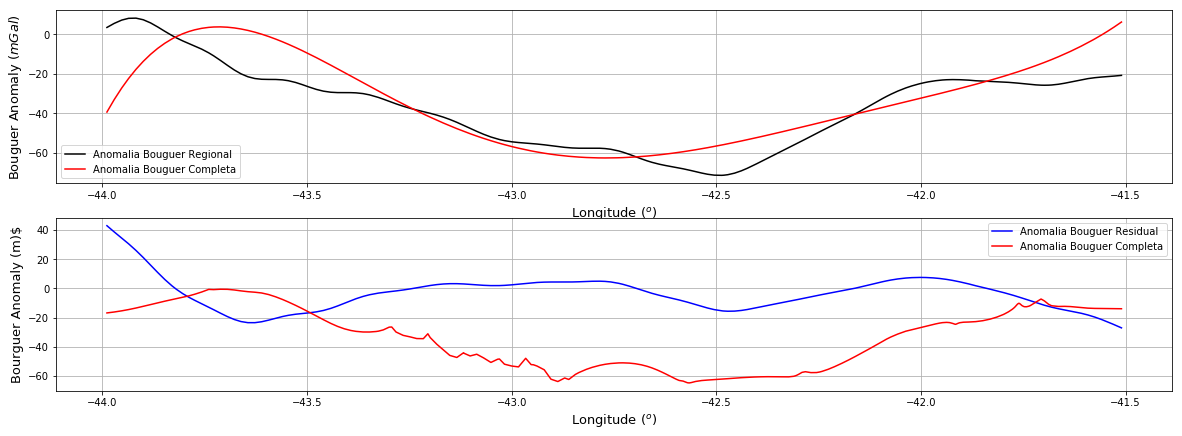

In [70]:
# ------------ set figure size: ------------------------------------------#
plt.close('all')

#### ATENÇÃO À ESCALA DAS FIGURAS!!!!! #########
fig = plt.figure(figsize=(20,7), facecolor='w')
plt.subplot(2,1,1)

plt.plot(lon,gzp,'-k', label='Anomalia Bouguer Regional')
plt.plot(lon,poly,'-r', label='Anomalia Bouguer Completa')
plt.xlabel('Longitude ($^o$)', fontsize = 13)
plt.ylabel('Bouguer Anomaly $(mGal)$', fontsize = 13)
plt.legend()
plt.grid()
###########################################################################################################################

plt.subplot(2,1,2)
plt.plot(lon,aa,'-b', label='Anomalia Bouguer Residual')
plt.plot(lon,gzi,'-r', label='Anomalia Bouguer Completa')
plt.xlabel('Longitude ($^o$)', fontsize = 13)
plt.ylabel('Bourguer Anomaly (m)$', fontsize = 13)
plt.legend()
plt.grid()
plt.show()

In [65]:
gzi_t = gzp + res 

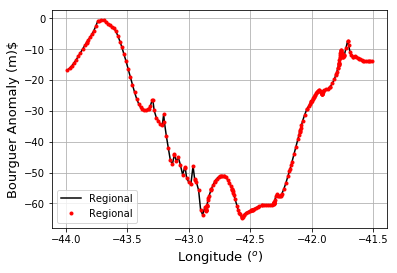

In [66]:
plt.plot(lon,gzi_t,'-k', label='Regional')
plt.plot(lon,gzi,'.r', label='Regional')
plt.xlabel('Longitude ($^o$)', fontsize = 13)
plt.ylabel('Bourguer Anomaly (m)$', fontsize = 13)
plt.legend()
plt.grid()
plt.show()


### Coordenadas x y da projeção cartográfica

In [ ]:
# calculo da area onde serao plotadas as imagens:
lon_min = np.min(lon_sat)
lon_max = np.max(lon_sat)
lat_min = np.min(lat_sat)
lat_max = np.max(lat_sat)
area = [lon_min, lon_max, lat_min, lat_max]
print (area)

## Plot gravity anomaly into georeferenced map using basemap function: 

In [ ]:
#%matplotlib inline
#%%python2
# ------------ set figure size: ------------------------------------------#
plt.close('all')
fig = plt.figure(figsize=(17,9), facecolor='w')

# ------------------------- Define the center of the map -----------------------------------#  
lon0 = 0.5*(area[0] + area[1])
lat0 = 0.5*(area[2] + area[3])

# ------- use basemap function to create the plot : ---------# 
m = Basemap(llcrnrlon=area[0],llcrnrlat=area[2],
            urcrnrlon=area[1],urcrnrlat=-2., 
            resolution='l',projection='tmerc', 
            lon_0=lon0, lat_0=lat0,epsg=3395)


#----------Drawing Lat Long: -------------#
m.drawmeridians(range(0,360,1), labels=[0, 1, 0, 1], latmax=area[1])
m.drawparallels(range(-90,90,1), labels=[1, 0, 1, 0],latmax=area[3])
m.drawmapscale(-44.5, -3.8, lon_max, lat_max, 100, 'simple', fontcolor = 'w')

#------------------Loading Shapefiles---------------#
#m.readshapefile('brazil_shapefile/BRA_adm0', 'Brasil', drawbounds=True, linewidth=1)
#m.readshapefile('Real/shapes/MatoGrossodoSul', 'MatoGrossodoSul', drawbounds=True, linewidth=1)
#m.readshapefile('Real/shapes/Parana', 'Parana', drawbounds=True, linewidth=1)
#m.readshapefile('../dados_reais/shapeFiles/bacias/Limite_das_Bacias_Sedimentares', 'Limite_das_Bacias_Sedimentares', drawbounds=True, linewidth=1)

#--------------Background satellite image options-----------#

#m.shadedrelief(scale=1)
#m.etopo(scale=2)
#m.bluemarble(scale=0.5)
m.arcgisimage(service='ESRI_Imagery_World_2D', xpixels = 500, verbose= True)
#m.arcgisimage(service='World_Shaded_Relief', xpixels = 500, ypixels= 500, verbose= True)

# TODO: make a accurate scale for the map
#---------------- Scaling the map---------------#
#m.drawmapscale(lon0, area[0], area[1], area[3], 250, barstyle='fancy')


# ---- Plot the profile data over the map as a scatter plot:
k = m.scatter(lon, y, s=25.0, c=gzi_reg, marker='.', cmap=plt.cm.RdBu_r, latlon=True)

#----- colorbar specifications -----:
cbar.set_label('Bouguer Anomaly $ (mGal) $',fontsize=12, rotation=90, )

#------------------Anomaly map------------------#
k = m.contourf(lon_sat, lat_sat, gz_sat, 20, tri=True, cmap='RdBu_r', 
               latlon=True, alpha=0.6, vmin=min(gz_sat), vmax=max(gz_sat) )

#----- colorbar specifications -----:
cbar = m.colorbar(k, location='bottom', size="5%", pad="15%")
cbar.set_label('Bouguer Anomaly $ (mGal) $',fontsize=13, rotation=0)
#-------------Add Title-----------------------#
#plt.title('S ', fontsize=16, pad='10')
#plt.savefig('barreirinhas_map.png', dpi=600, transparent=True, bbox_inches='tight')
#plt.savefig('barreirinhas_map.pdf', dpi=600, transparent=True, bbox_inches='tight')
plt.show()

In [ ]:
# ------------ set figure size: ------------------------------------------#
%matplotlib inline
plt.close('all')
fig = plt.figure(figsize=(17,9))

# ------------------------- Define the center of the map -----------------------------------#  
lon0 = 0.5*(area[0] + area[1])
lat0 = 0.5*(area[2] + area[3])

# ------- use basemap function to create the plot : ---------# 
m = Basemap(llcrnrlon=area[0],llcrnrlat=area[2],
            urcrnrlon=area[1],urcrnrlat=-2., 
            resolution='l',projection='tmerc', 
            lon_0=lon0, lat_0=lat0,epsg=3395)


#----------Drawing Lat Long: -------------#
m.drawmeridians(range(0,360,1), labels=[0, 1, 0, 1], latmax=area[1])
m.drawparallels(range(-90,90,1), labels=[1, 0, 1, 0],latmax=area[3])
m.drawmapscale(-44.5, -3.8, lon_max, lat_max, 100, 'simple', fontcolor = 'w')

#------------------Loading Shapefiles---------------#
#m.readshapefile('brazil_shapefile/BRA_adm0', 'Brasil', drawbounds=True, linewidth=1)
#m.readshapefile('Real/shapes/MatoGrossodoSul', 'MatoGrossodoSul', drawbounds=True, linewidth=1)
#m.readshapefile('Real/shapes/Parana', 'Parana', drawbounds=True, linewidth=1)
m.readshapefile('../dados_reais/bacias/Limite_das_Bacias_Sedimentares', 'Limite_das_Bacias_Sedimentares', 
                drawbounds=True, linewidth=1)
#--------------Background satellite image options-----------#

#m.shadedrelief(scale=1)
#m.etopo(scale=2)
#m.bluemarble(scale=0.5)
m.arcgisimage(service='ESRI_Imagery_World_2D', xpixels = 500, verbose= True)
#m.arcgisimage(service='World_Shaded_Relief', xpixels = 500, ypixels= 500, verbose= True)

# TODO: make a accurate scale for the map
#---------------- Scaling the map---------------#
#m.drawmapscale(lon0, area[0], area[1], area[3], 250, barstyle='fancy')


# ---- Plot the profile data over the map as a scatter plot:
k = m.scatter(lon, y, s=25.0, c=gzi, marker='.', cmap=plt.cm.coolwarm, latlon=True)
#k = m.scatter(lon, lat, s=25.0, c=gz, marker='.', cmap=plt.cm.coolwarm, latlon=True)

#----- colorbar specifications -----:
cbar.set_label('Terrestrial Bouguer $ (mGal) $',fontsize=12, rotation=90, )

#------------------Anomaly map------------------#
#k = m.contourf(lon_sat, lat_sat, gz_sat, 20, tri=True, cmap=plt.cm.coolwarm, 
#               latlon=True, alpha=0.5, vmin=min(gz_sat), vmax=max(gz_sat) )

#----- colorbar specifications -----:
cbar = m.colorbar(k, location='bottom', size="5%", pad="15%")
cbar.set_label('Bouguer Anomaly $ (mGal) $',fontsize=13, rotation=0)
#-------------Add Title-----------------------#
#plt.title('Gravity study of Barreirinhas Basin', fontsize=16, pad='10')
#plt.savefig('barreirinhas_map2.png', dpi=600, transparent=True, bbox_inches='tight')
#plt.savefig('barreirinhas_map2.pdf', dpi=600, transparent=True, bbox_inches='tight')
plt.show()

In [ ]:
# calculando a conversao dos dados do perfil para utm:
size = len(lon)
utmx = np.zeros( size )
utmy = np.copy(utmx)

for i in range(size):
    # N = north, E = East
    #print (i)
   #if lon[i] > -42.0:        
    XXX = utm.from_latlon( y[i], lon[i], force_zone_number=23 )
    utmx[i], utmy[i] = XXX[1], XXX[0] 
    #else:
    #    XXX = utm.from_latlon( y[i], lon[i], force_zone_number=23 )
    #    utmy[i], utmx[i] = XXX[1], XXX[0]

In [ ]:
# plot do perfil para verificacao:
# ------------ set figure size: ------------------------------------------#
plt.close('all')

#### ATENÇÃO À ESCALA DAS FIGURAS!!!!! #########
fig = plt.figure(figsize=(20,7), facecolor='w')
plt.plot(utmy,utmx,'*k', label='Interpolated')
plt.xlabel('UTMY ($m$)', fontsize = 13)
plt.ylabel('UTMX $m$', fontsize = 13)
plt.legend()
plt.grid()


In [ ]:
# Salvando arquivo para georeferenciamento no mapa geológico de barreirinhas:
g = {"utmx": utmx, 'utmy':utmy}
type(g)
geo_ref = pd.DataFrame( data=g )

# salvando arquivo para georeferenciamento:
#geo_ref.to_csv(caminhomat +'xy_perfil.txt', sep = ' ', encoding='utf-8', index=False)
geo_ref.to_csv(caminhorod +'xy_perfil.txt', sep = ' ', encoding='utf-8', index=False)

## <center> Salvando arquivo com os dados em perfil: <center>

In [ ]:
# Salvando arquivo para georeferenciamento no mapa geológico de barreirinhas:
names = ['Utmx', 'Utmy', 'H(m)', 'mGal']
g = {"utmx": utmx, 'utmy':utmy, "H(m)":elevi, "mGal": gzi}
geo_ref = pd.DataFrame(g)
#print geo_ref

# salvando arquivo para georeferenciamento for Mathews:
#geo_ref.to_csv(caminhomat + 'barreirinhas_perfil.txt', sep = ' ', encoding='utf-8', index=False)
geo_ref.to_csv(caminhorod +'barreirinhas_perfil.txt', sep = ' ', encoding='utf-8', index=False)

## TODO: incorporar os plots dos pocos que eventualmente serao considerados para analise no trabalho!

## <center> End of the script ! <center>